In [1]:
# imports
import pathlib
import datetime
import random
import numpy as np
import json
import torch
import torch.nn as nn

from tqdm import tqdm
from IPython.display import clear_output
from models import NCA_grow_learnable, NCA_grow_laplace, NCA_grow_sobel
from utils import Utils

from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec

In [2]:
def show_image(img, channel=None):
    img_rgb = Utils.to_rgb(img).squeeze().permute(1, 2, 0)
    print ('img_rgb.shape: ', img_rgb.shape)
    if channel is not None:
        c = img_rgb[:,:, channel]
        channels = img_rgb.shape[2]
        for i in range(channels):
            if i != channel:
                img_rgb[:,:, i] = torch.zeros((img_rgb.shape[0], img_rgb.shape[1]))
        
    plt.axis('off')
    plt.imshow(img_rgb)
    plt.show()

def show_batch(batch_size, before, after, dpi=256):
    fig = plt.figure(figsize=(batch_size, 2), dpi=dpi)
    axarr = fig.subplots(nrows=2, ncols=batch_size)
    gspec = gridspec.GridSpec(2, batch_size)
    gspec.update(wspace=0.1, hspace=0) # set the spacing between axes.
    plt.clf()
    
    for i in range(batch_size):
        img_i = before[i]
        img_i = img_i[:4].unsqueeze(0)
        img_rgb = Utils.to_rgb(img_i).squeeze().permute(1, 2, 0)
        axarr[0, i] = plt.subplot(gspec[i])
        axarr[0, i].set_xticks([])
        axarr[0, i].set_yticks([])
        axarr[0, i].imshow(img_rgb, aspect='equal')
        axarr[0, i].set_title(str(i), fontsize=8)
        
    for i in range(batch_size):
        img_i = after[i]
        img_i = img_i[:4].unsqueeze(0)
        img_rgb = Utils.to_rgb(img_i).squeeze().permute(1, 2, 0)
        axarr[1, i] = plt.subplot(gspec[i+batch_size])
        axarr[1, i].set_xticks([])
        axarr[1, i].set_yticks([])
        axarr[1, i].imshow(img_rgb, aspect='equal')
        
    plt.show()

In [3]:
# code block used for experiments

seed = Utils.make_seed(16, 16)
pad = 16
seed = nn.functional.pad(seed, (pad, pad, pad, pad), 'constant', 0)
pool = seed.clone().repeat(8, 1, 1, 1)

#show_batch(8, pool, pool)

In [4]:
# code block used for experiments

import sys
np.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(threshold=sys.maxsize)
torch.set_printoptions(profile="full")

x = torch.rand(2, 3, 3, 3)
#print (x)

z = torch.zeros(1, 3, 3, 1)
x[-1:] *= z
#print (x)

In [5]:
# code block used for experiments

# identity vector
identity_filter = torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=torch.float32)

# create sobel filters
batch_size = 1
n_channels = 4
size = 3
angle = 0.0
scalar = 1.0
dx = np.outer([1, 2, 1], [-1, 0, 1]) / scalar # Sobel filter
dy = dx.T
c, s = np.cos(angle), np.sin(angle)
sobel_filter_x = torch.tensor(c*dx-s*dy, dtype=torch.float32)
sobel_filter_y = torch.tensor(s*dx+c*dy, dtype=torch.float32)

x = torch.randint(1, 5, (batch_size, n_channels, size, size), dtype=torch.float32)
print ('preception!')
print ('x.shape: ', x.shape)
#print (x)

# stack filters together
sobel_filters = torch.stack([sobel_filter_x, sobel_filter_y]) # (2, 3, 3)
print ('sobel_filters.shape: ', sobel_filters.shape)
#print (filters)

sobel_filters = sobel_filters.repeat((n_channels, 1, 1)) # (2 * n_channels, 3, 3)
ident_filters = identity_filter.repeat((n_channels, 1, 1)) # (n_channels, 3, 3)
print ('sobel_filters.shape: ', sobel_filters.shape)
print ('ident_filters.shape: ', ident_filters.shape)
#print (filters)

sobel_filters = sobel_filters[:, None, ...] # (2 * n_channels, 1, 3, 3)
ident_filters = ident_filters[:, None, ...] # (2 * n_channels, 1, 3, 3)
print ('sobel_filters.shape: ', sobel_filters.shape)
print ('ident_filters.shape: ', ident_filters.shape)
#print (sobel_filters)

sobel_res = nn.functional.conv2d(x, sobel_filters, padding=1, groups=4)
ident_res = nn.functional.conv2d(x, ident_filters, padding=1, groups=4)
print ('sobel_res.shape: ', sobel_res.shape)
#print (sobel_res)
#print ('ident_res.shape: ', ident_res.shape)
#print (ident_res)

sobel_square = torch.square(sobel_res)
sobel_mag = torch.zeros_like(x)
count = 0
for i in range(0, (n_channels*2), 2):
    mag = torch.sqrt(sobel_square[:,i] + sobel_square[:,i+1])
    sobel_mag[:,count] = mag
    count += 1

print ('sobel_mag.shape: ', sobel_mag.shape)
#print (sobel_mag)

res = torch.cat((ident_res, sobel_mag), dim=1)
print ('res.shape: ', res.shape)
#print (res)

# return res

preception!
x.shape:  torch.Size([1, 4, 3, 3])
sobel_filters.shape:  torch.Size([2, 3, 3])
sobel_filters.shape:  torch.Size([8, 3, 3])
ident_filters.shape:  torch.Size([4, 3, 3])
sobel_filters.shape:  torch.Size([8, 1, 3, 3])
ident_filters.shape:  torch.Size([4, 1, 3, 3])
sobel_res.shape:  torch.Size([1, 8, 3, 3])
sobel_mag.shape:  torch.Size([1, 4, 3, 3])
res.shape:  torch.Size([1, 8, 3, 3])


In [6]:
# training parameters
img = '..\\_images\\rainbow.png'
name = 'cowboy_learnable'
model_type = 'learnable'
viz_train = True

size = 40
pad = 12
n_channels = 16
hid_channels = 128
fire_rate = 0.5

n_train_iter = 3000
batch_size = 8
pool_size = 32
n_damage = 3
iter_start_damage = 500

checkpoint_freq = 1000
eval_freq = 500
eval_iter = 300

log_dir = 'logs'
model_dir = 'models'
checkpoint_dir = 'checkpoints'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print ('cuda available? ', torch.cuda.is_available())
print ('device: ', device)

cuda available?  True
device:  cuda


loaded_img.shape:  torch.Size([1, 4, 40, 40])
torch.Size([1, 4, 40, 40])
torch.Size([1, 4, 64, 64])
target_img.shape:  torch.Size([8, 4, 64, 64])
target image: 
img_rgb.shape:  torch.Size([40, 40, 3])


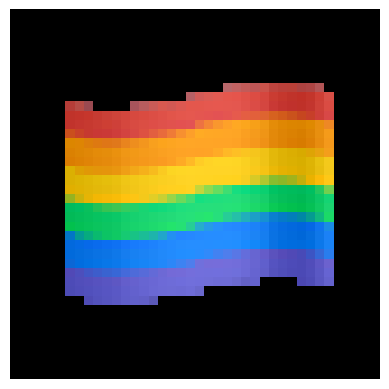

In [7]:
# misc
full_size = size + (2 * pad)
#device_n = torch.device(device)

# create log
log_path = pathlib.Path(log_dir)
log_path.mkdir(parents=True, exist_ok=True)

# target image
loaded_img = Utils.load_image(img, size)
print('loaded_img.shape: ', loaded_img.shape)
print (loaded_img.shape)

target_img_ = nn.functional.pad(loaded_img, (pad, pad, pad, pad), 'constant', 0)

print (target_img_.shape)

target_img = target_img_.to(device)
target_img = target_img.repeat(batch_size, 1, 1, 1)
print ('target_img.shape: ', target_img.shape)

# show image
print ('target image: ')
show_image(loaded_img)

sobel x
img_rgb.shape:  torch.Size([64, 64, 3])


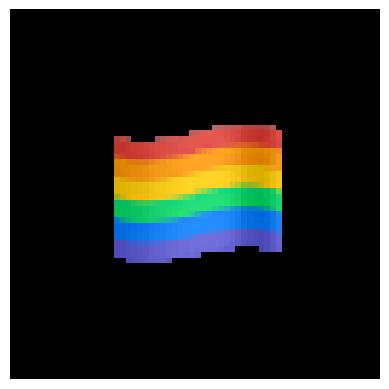

red channel
img_rgb.shape:  torch.Size([64, 64, 3])


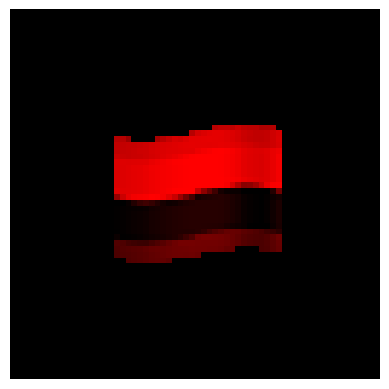

green channel
img_rgb.shape:  torch.Size([64, 64, 3])


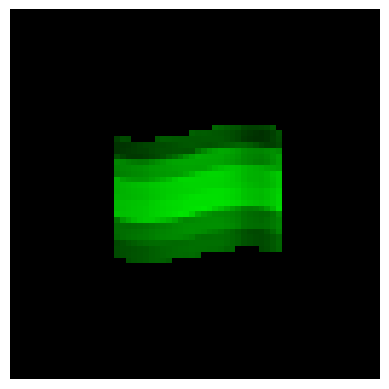

blue channel
img_rgb.shape:  torch.Size([64, 64, 3])


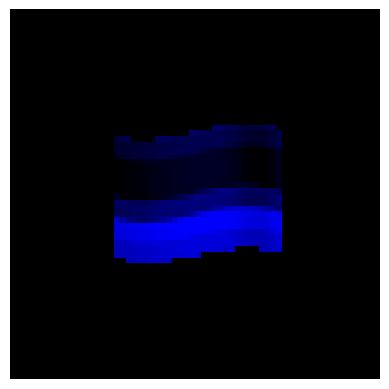

In [8]:
print ('sobel x')
show_image(target_img_)
print ('red channel')
show_image(target_img_, 0)
print ('green channel')
show_image(target_img_, 1)
print ('blue channel')
show_image(target_img_, 2)

In [9]:
x0 = torch.randint(1, 8, (3, 3), dtype=torch.float32)
print(x0)
x1 = torch.square(x0)
print(x1)
x2 = torch.sqrt(x1)
print(x2)
print (x0 == x2)

y = torch.randint(1, 8, (3, 3), dtype=torch.float32)
print (y == torch.sqrt(torch.square(y)))

tensor([[5., 6., 3.],
        [4., 4., 6.],
        [2., 1., 5.]])
tensor([[25., 36.,  9.],
        [16., 16., 36.],
        [ 4.,  1., 25.]])
tensor([[5., 6., 3.],
        [4., 4., 6.],
        [2., 1., 5.]])
tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])
tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])


tensor([[-1.,  0.,  1.],
        [-2.,  0.,  2.],
        [-1.,  0.,  1.]])
tensor([[ 0.,  1.,  0.],
        [ 1., -4.,  1.],
        [ 0.,  1.,  0.]])
G_x.shape:  torch.Size([1, 4, 64, 64])
G_x
img_rgb.shape:  torch.Size([64, 64, 3])


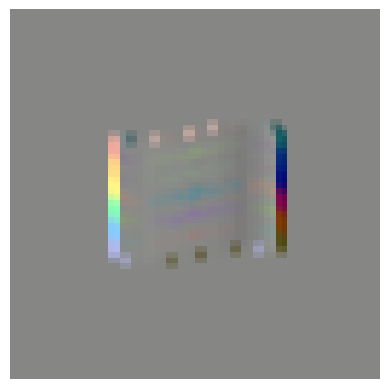

G_x red channel
img_rgb.shape:  torch.Size([64, 64, 3])


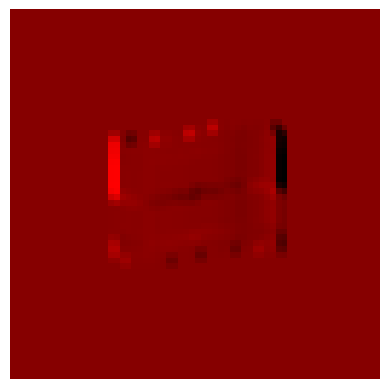

G_x green channel
img_rgb.shape:  torch.Size([64, 64, 3])


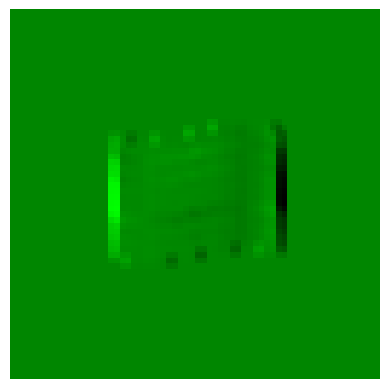

G_x blue channel
img_rgb.shape:  torch.Size([64, 64, 3])


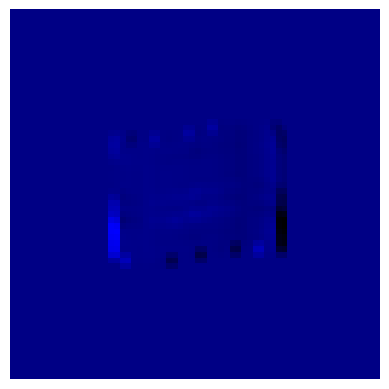

G_y.shape:  torch.Size([1, 4, 64, 64])
G_y
img_rgb.shape:  torch.Size([64, 64, 3])


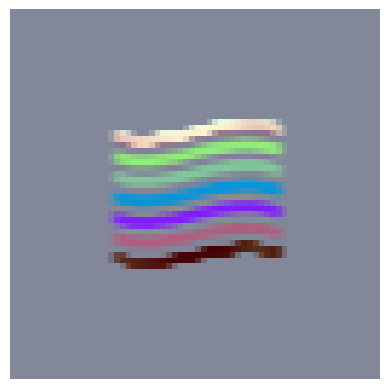

G_y red channel
img_rgb.shape:  torch.Size([64, 64, 3])


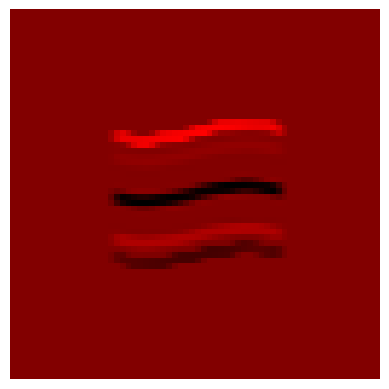

G_y green channel
img_rgb.shape:  torch.Size([64, 64, 3])


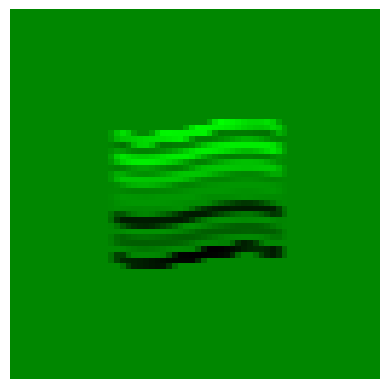

G_y blue channel
img_rgb.shape:  torch.Size([64, 64, 3])


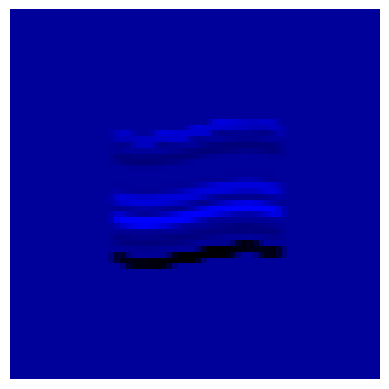

G_x^2
img_rgb.shape:  torch.Size([64, 64, 3])


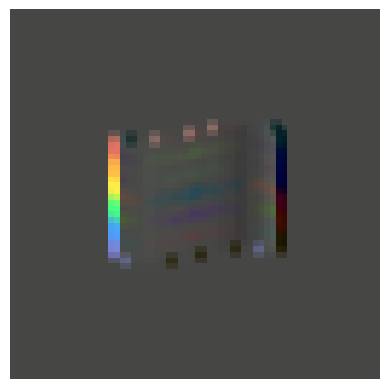

G_y^2
img_rgb.shape:  torch.Size([64, 64, 3])


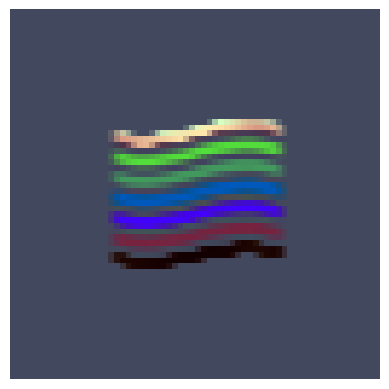

G_laplace
img_rgb.shape:  torch.Size([64, 64, 3])


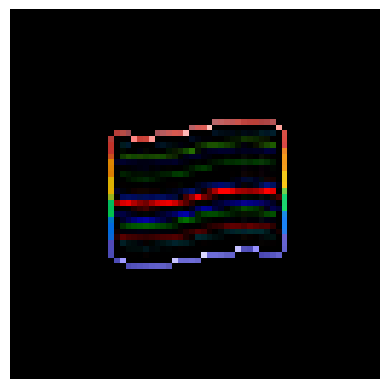

G_identity
img_rgb.shape:  torch.Size([64, 64, 3])


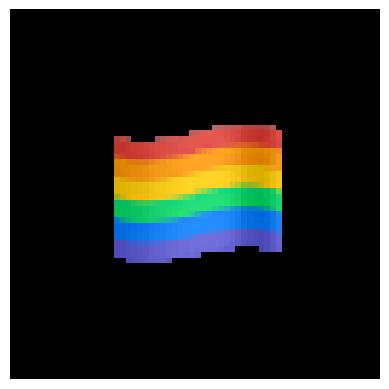

mag:
img_rgb.shape:  torch.Size([64, 64, 3])


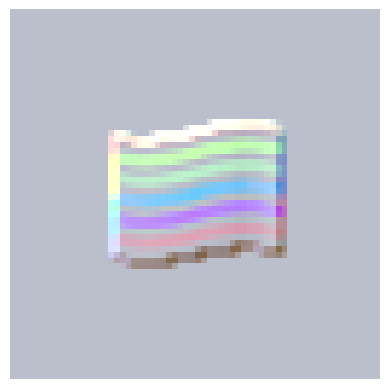

In [10]:
_n_channels = 4
_angle = 0.0
_scalar = 1.0

dx = np.outer([1, 2, 1], [-1, 0, 1]) / _scalar # sobel filter
dy = dx.T
c, s = np.cos(_angle), np.sin(_angle)
sobel_x = torch.tensor(c*dx-s*dy, dtype=torch.float32)
sobel_y = torch.tensor(s*dx+c*dy, dtype=torch.float32)
laplace = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32)
laplace /= _scalar
identty = torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]], dtype=torch.float32)

print (sobel_x)
print (laplace)

# sobel_x = torch.tensor([[0,0,0],[0,0,0],[0,0,0]], dtype=torch.float32)
# sobel_y = torch.tensor([[0,0,0],[0,0,0],[0,0,0]], dtype=torch.float32)

sobel_x = sobel_x.repeat((_n_channels, 1, 1)) # (n_channels, 3, 3)
sobel_y = sobel_y.repeat((_n_channels, 1, 1)) # (n_channels, 3, 3)
laplace = laplace.repeat((_n_channels, 1, 1)) # (n_channels, 3, 3)
identty = identty.repeat((_n_channels, 1, 1)) # (n_channels, 3, 3)

sobel_x = sobel_x[:, None, ...] # (n_channels, 1, 3, 3)
sobel_y = sobel_y[:, None, ...] # (n_channels, 1, 3, 3)
laplace = laplace[:, None, ...] # (n_channels, 1, 3, 3)
identty = identty[:, None, ...] # (n_channels, 1, 3, 3)

# 2d conv
G_x = nn.functional.conv2d(target_img_, sobel_x, padding=1, groups=_n_channels)
G_y = nn.functional.conv2d(target_img_, sobel_y, padding=1, groups=_n_channels)
G_l = nn.functional.conv2d(target_img_, laplace, padding=1, groups=_n_channels)
G_i = nn.functional.conv2d(target_img_, identty, padding=1, groups=_n_channels)

for i in range(4):
    min_y = torch.min(G_y[:, i])
    max_y = torch.max(G_y[:, i])
    # Shift the values from [min, max] to [0, 1]
    G_y[:, i] = G_y[:, i]+abs(min_y)
    # Scale the values from [0, 2] to [0, 1]
    div_y = (abs(min_y)+abs(max_y))
    if div_y != 0:
        G_y[:, i] = G_y[:, i]/div_y
    
    min_x = torch.min(G_x[:, i])
    max_x = torch.max(G_x[:, i])
    # Shift the values from [-1, 1] to [0, 2]
    G_x[:, i] = G_x[:, i]+abs(min_x)
    # Scale the values from [0, 2] to [0, 1]
    div_x = (abs(min_x)+abs(max_x))
    if div_x != 0:
        G_x[:, i] = G_x[:, i]/div_x
        
print ('G_x.shape: ', G_x.shape)
print ('G_x')
show_image(G_x)
print ('G_x red channel')
show_image(G_x, 0)
print ('G_x green channel')
show_image(G_x, 1)
print ('G_x blue channel')
show_image(G_x, 2)

print ('G_y.shape: ', G_y.shape)
print ('G_y')
show_image(G_y)
print ('G_y red channel')
show_image(G_y, 0)
print ('G_y green channel')
show_image(G_y, 1)
print ('G_y blue channel')
show_image(G_y, 2)

G_x2 = torch.square(G_x)
G_y2 = torch.square(G_y)
print ('G_x^2')
show_image(G_x2)
print ('G_y^2')
show_image(G_y2)

print ('G_laplace')
show_image(G_l)
print ('G_identity')
show_image(G_i)

sobel_mag = torch.zeros_like(target_img_)

for i in range(0, _n_channels):
    sobel_mag[:,i] = torch.sqrt(G_x2[:,i]+G_y2[:,i])

# show_image(G_x2)
# show_image(G_y2)

print ('mag:')
show_image(sobel_mag)


In [11]:
# save model
def save_model(_dir, _model, _name = None):
    model_path = pathlib.Path(_dir)
    model_path.mkdir(parents=True, exist_ok=True)
    if _name == None:
        ts = str(datetime.datetime.now()).replace(' ', '_').replace(':', '-').replace('.', '-')
        _name = 'model_' + ts
    torch.save(_model.state_dict(), _dir + '\\' + _name + '.pt')
    
    # save model parameters
    dict = {
        "img": img,
        "batch_size": batch_size,
        "device": device,
        "eval_freq": eval_freq,
        "eval_iter": eval_iter,
        "n_train_iter": n_train_iter,
        "n_channels": n_channels,
        "log_dir": log_dir,
        "pad": pad,
        "pool_size": pool_size,
        "size": size,
        "model_dir": _dir,
        "name": _name,
        "damage": n_damage,
        "model_type": model_type
    }
    json_object = json.dumps(dict, indent=4)
    with open(_dir + '\\' + _name + '_params.json', 'w') as outfile:
        outfile.write(json_object)
        print ('model saved!')

In [12]:
# model and optimizer
load_checkpoint = False
checkpoint = 'cowboy_learnable_cp1.pt'

print ('model type: ', model_type)
if model_type == 'learnable':
    model = NCA_grow_learnable(_n_channels=n_channels, _hid_channels=hid_channels, _fire_rate=fire_rate, _device=device)
elif model_type == 'laplace':
    model = NCA_grow_laplace(_n_channels=n_channels, _hid_channels=hid_channels, _fire_rate=fire_rate, _device=device)
elif model_type == 'sobel':
    model = NCA_grow_sobel(_n_channels=n_channels, _hid_channels=hid_channels, _fire_rate=fire_rate, _device=device)

if load_checkpoint:
    model.load_state_dict(torch.load(checkpoint_dir + '\\' + checkpoint, map_location=device))
    print ('loaded checkpoint!')
    
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

model type:  learnable
loaded checkpoint!


  0%|          | 0/3000 [00:00<?, ?it/s]

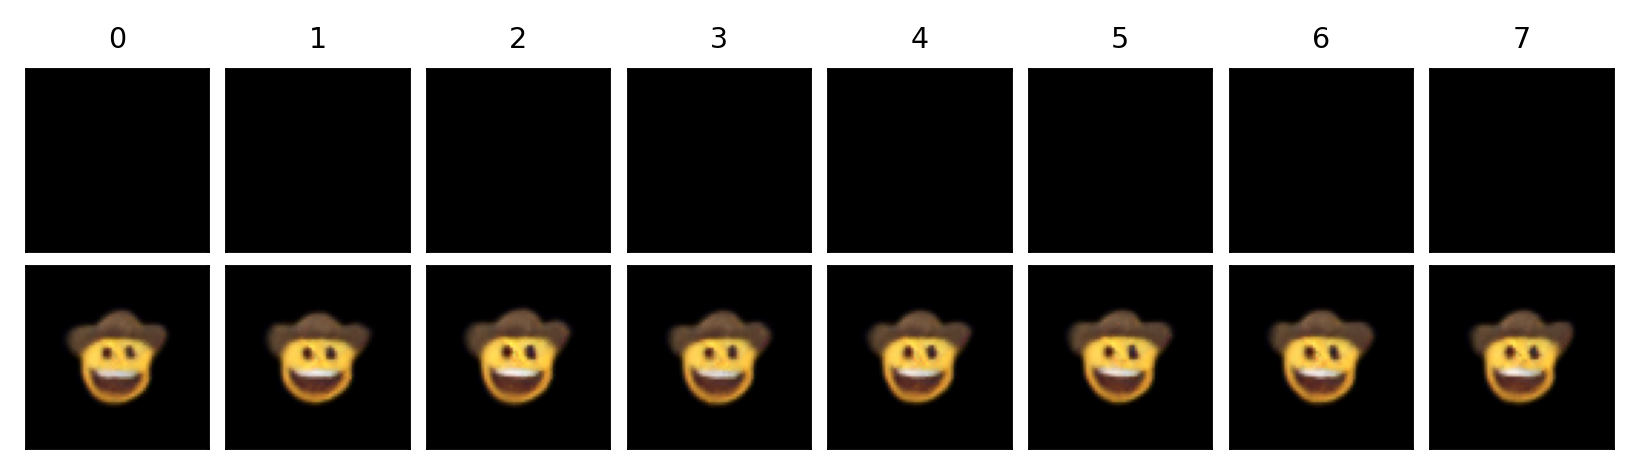

  0%|          | 1/3000 [00:04<4:04:08,  4.88s/it]

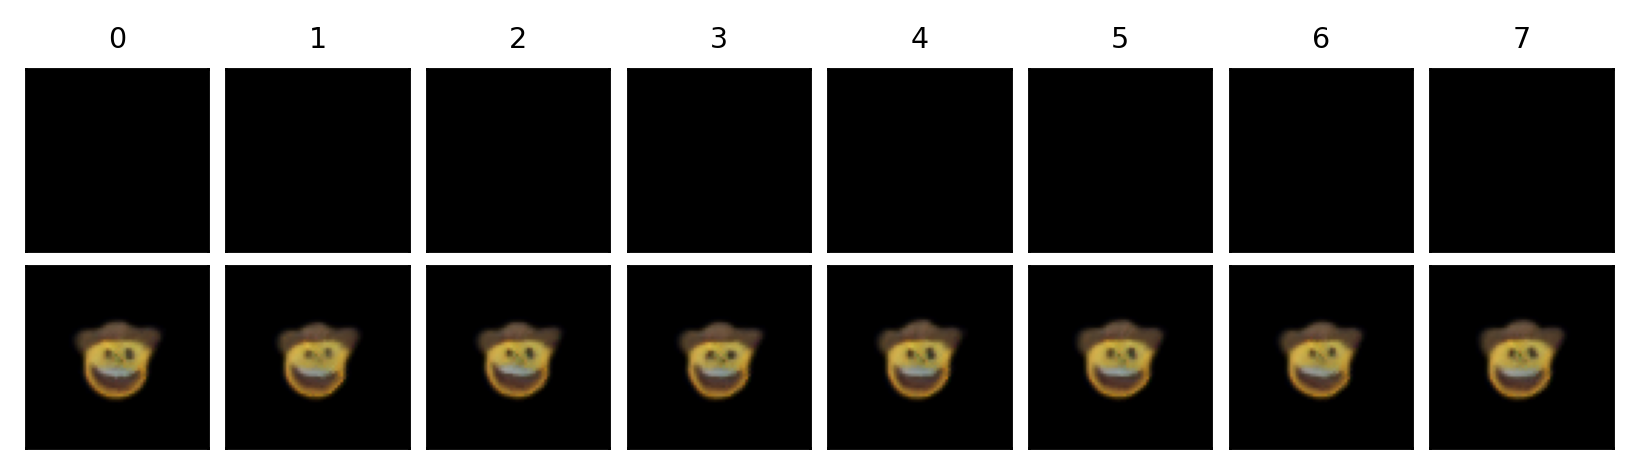

  0%|          | 2/3000 [00:06<2:33:37,  3.07s/it]

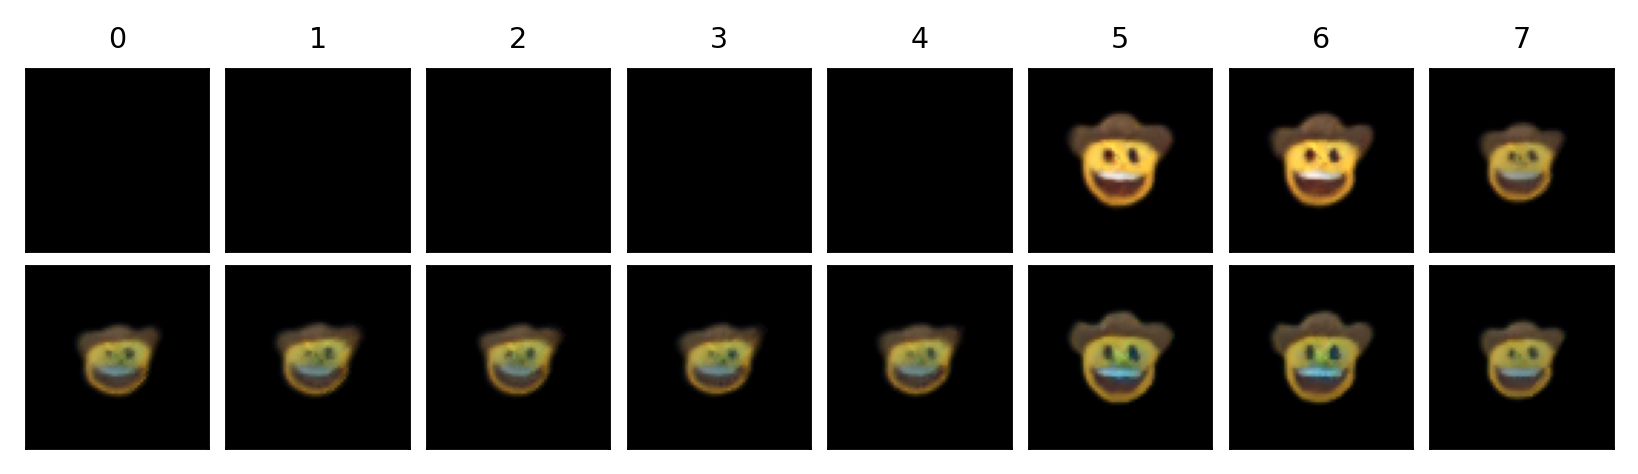

  0%|          | 3/3000 [00:08<2:03:22,  2.47s/it]

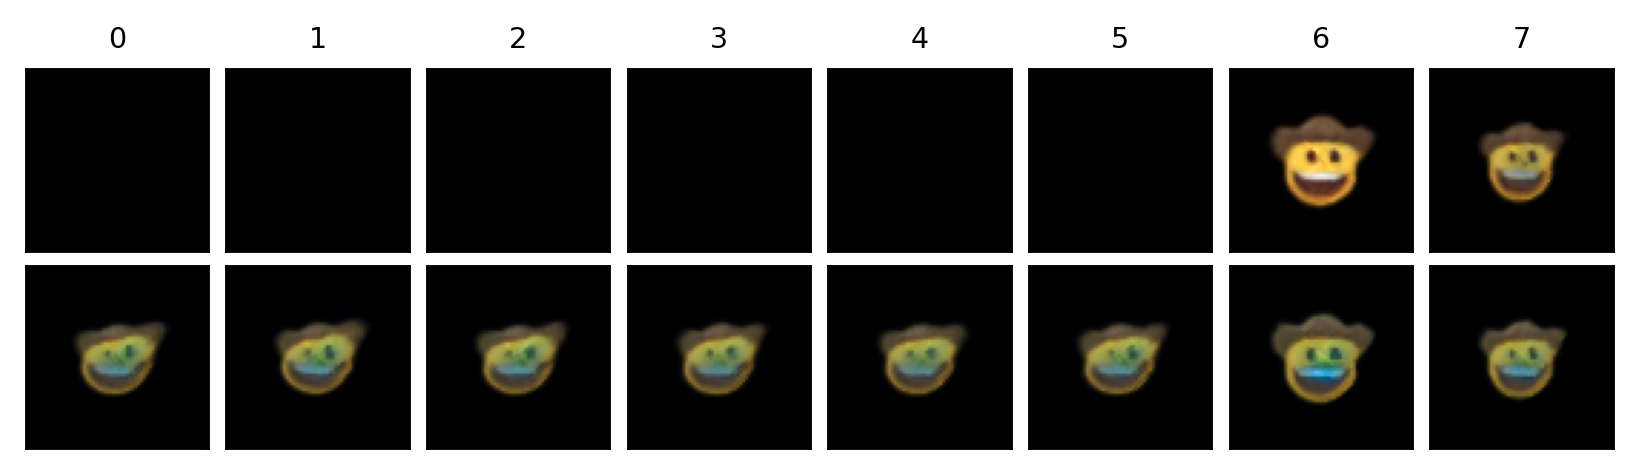

  0%|          | 4/3000 [00:10<1:51:56,  2.24s/it]

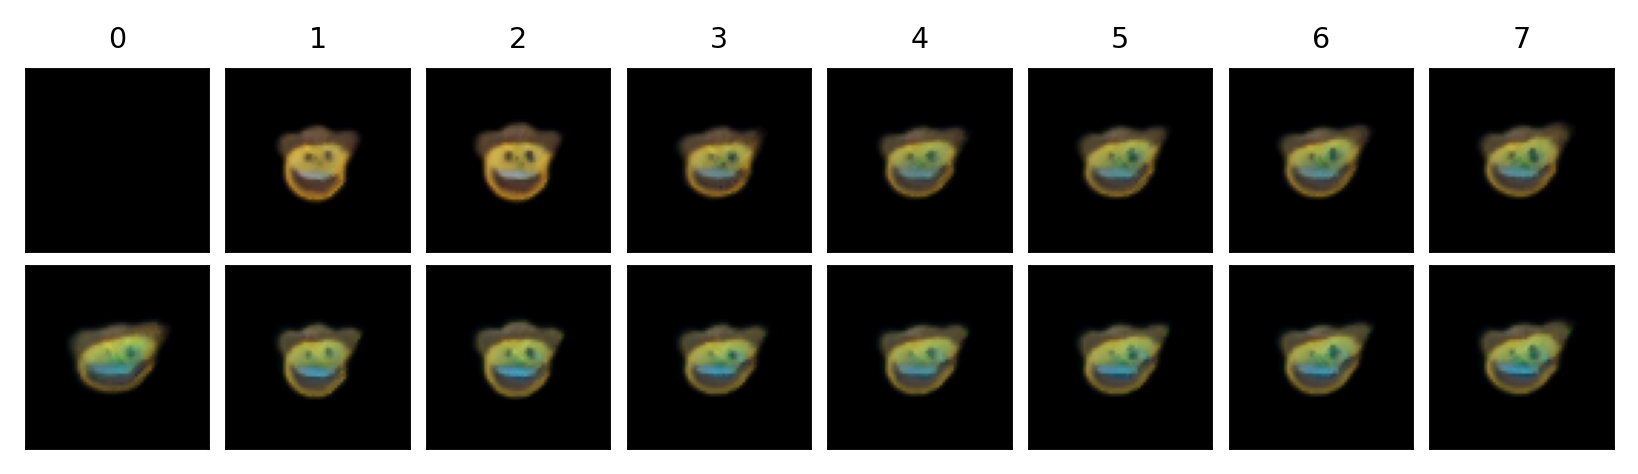

  0%|          | 5/3000 [00:11<1:35:27,  1.91s/it]

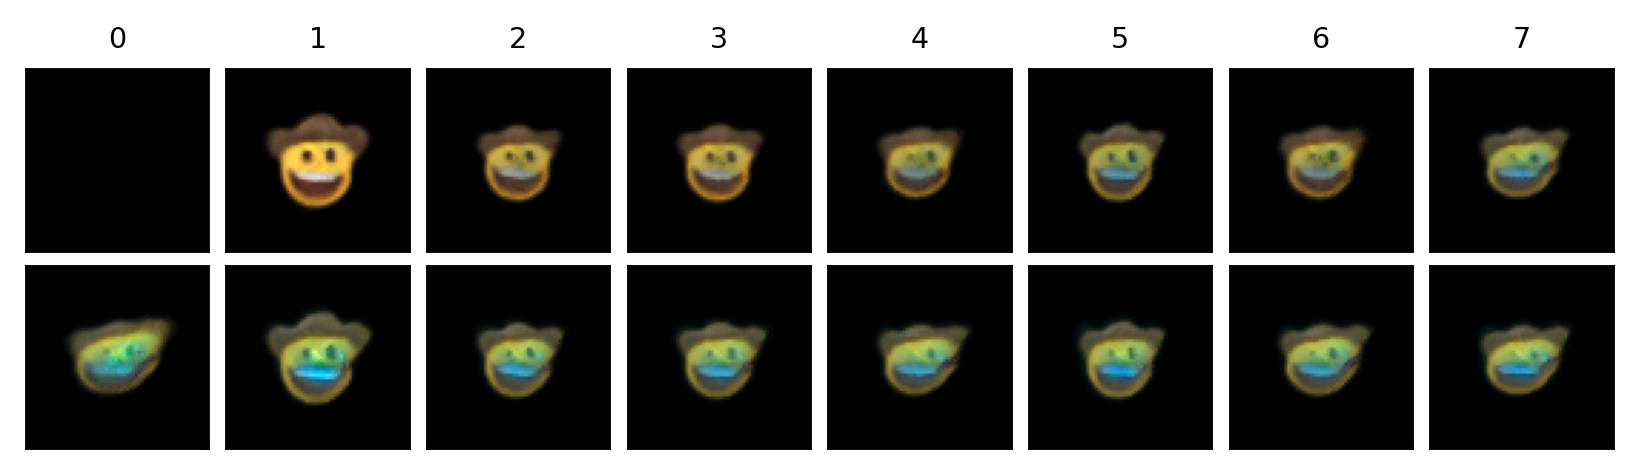

  0%|          | 6/3000 [00:13<1:49:57,  2.20s/it]


KeyboardInterrupt: 

In [13]:
# training loop begin

# pool init
seed = Utils.make_seed(size, n_channels).to(device)
seed = nn.functional.pad(seed, (pad, pad, pad, pad), 'constant', 0)
pool = seed.clone().repeat(pool_size, 1, 1, 1)
cp_count = 0

def loss_f(x):
    return ((target_img - x[:, :4, ...]) ** 2).mean(dim=[1, 2, 3])

# training loop
for it in tqdm(range(n_train_iter)):
    batch_ixs = np.random.choice(
        pool_size, batch_size, replace=False
    ).tolist()
    
    # get training batch and set first in batch as seed
    x = pool[batch_ixs]

    # sort batch by loss, replace the highest-loss sample with the seed.
    loss_rank = loss_f(x).detach().cpu().numpy().argsort()[::-1]
    x = x[loss_rank.copy()]
    x[0] = seed.clone()
    
    # damage examples in batch
    if n_damage > 0 and it > iter_start_damage:
        radius = random.uniform(size*0.1, size*0.35)
        u = random.uniform(0, 1) * size + pad
        v = random.uniform(0, 1) * size + pad
        mask = Utils.create_circle_mask(full_size, radius, [u, v])
        x[-n_damage:] *= torch.tensor(mask).to(device)
        
    # visualize batch
    if viz_train:
        before = x.detach().cpu()
    
    # forward pass
    for i in range(np.random.randint(64, 96)):
        x = model(x)
        
    loss_batch = ((target_img - x[:, :4, ...]) ** 2).mean(dim=[1, 2, 3])
    loss = loss_batch.mean()
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print ('train/loss: ', it, '/', loss.item())
    
    # visualize batch
    if viz_train:
        after = x.detach().cpu()
        show_batch(batch_size, before, after)
    
    # find best in batch
    argmax_batch = loss_batch.argmax().item()
    argmax_pool = batch_ixs[argmax_batch]
    remaining_batch = [i for i in range(batch_size) if i != argmax_batch]
    remaining_pool = [i for i in batch_ixs if i != argmax_pool]
    
    # replace most loss example with seed
    if it <= iter_start_damage:
        pool[argmax_pool] = seed.clone()
        pool[remaining_pool] = x[remaining_batch].detach()
    else:
        pool[batch_ixs] = x.detach()
    
    # clear output after 100 iterations
    if it % 100 == 0 and it != 0:
        clear_output(wait=True)
    
    # check for create checkpoint
    if it % checkpoint_freq == 0 and it > 0:
        save_model(checkpoint_dir, model, name + '_cp' + str(cp_count))
        cp_count += 1

# save final model
save_model(model_dir, model, name)

In [ ]:
# click here to watch batch viz





